# Load data

In [1]:
%matplotlib inline

In [2]:
import numpy as np 
import sklearn 
import scipy.misc
import matplotlib.pyplot as plt

In [3]:
# loading data
x_train = np.loadtxt("data/train_x.csv", delimiter=",")
y_train = np.loadtxt("data/train_y.csv", delimiter=",")
x_test = np.loadtxt("data/test_x.csv", delimiter=",")
print("Done")

Done


In [4]:
# encode y_train data in one-hot encoding
y_train_one_hot = [[0 for i in range(10)] for i in range(len(y_train))]
for i in range(len(y_train)):
    y_train_one_hot[i][int(y_train[i])] = 1

y_train_one_hot = np.array(y_train_one_hot)

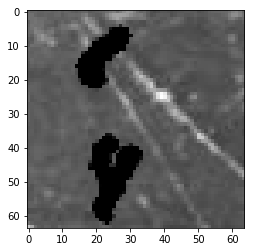

[ 4.]


In [5]:
def show_img(img):
    plt.close()
    plt.imshow(img, cmap='gray_r')
    plt.show()

x_train_reshaped = x_train.reshape(-1, 64, 64)
y_train_reshaped = y_train.reshape(-1, 1) 
x_test_reshaped = x_test.reshape(-1, 64, 64)

show_img(x_train_reshaped[0])
print(y_train_reshaped[0])

In [16]:
def clean_data(x):
    """
    Because the only thing that matters is the numbers in the picture, which are black, 
    we recode the pixels as 1 if the pixel was 255 and 0 otherwise. To reduce noise and to
    reduce overflow/underflow in later stages.
    """
    new_data = []
    for row in x:
        new_row = []
        for pixel in row:
            if pixel == 255:
                new_row.append(1)
            else:
                new_row.append(0)
        new_data.append(new_row)
    return np.array(new_data)



## Split training data into train / valid sets

In [17]:
from sklearn.model_selection import train_test_split
x_train_s, x_valid_s, y_train_s, y_valid_s = train_test_split(x_train, y_train_one_hot, train_size=0.8, test_size=0.2)
data = {
    "x_train": clean_data(x_train_s),
    "x_valid": clean_data(x_valid_s),
    "y_train": y_train_s,
    "y_valid": y_valid_s
}

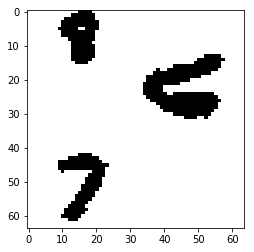

489


In [27]:
x_cleaned_reshaped = data["x_train"].reshape(-1, 64, 64)
show_img(x_cleaned_reshaped[1])

# Baseline Linear Classifier: Linear SVM

In [18]:
from sklearn import metrics
from sklearn.svm import LinearSVC

(40000, 4096)

In [10]:
def baseline_linear_svm(data):
    """
    Using out-of-the-box linear SVM to classify data
    """
    clf = LinearSVC()
    
    y_pred = clf.fit(data["x_train"], data["y_train"]).predict(data["x_valid"])
    print(y_pred)
    return metrics.accuracy_score(data["y_valid"], y_pred, average="macro"), y_pred
    
# score, y_pred = baseline_linear_svm(data)
# print(score)

0.0988


# Neural Network

In [118]:
def sigmoid(x):
    """
    sigmoid function
    """
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    """
    derivative of sigmoid
    """
    return x * (1. - x)

def tanh(x):
    """
    tanh function
    """
    return np.tanh(x)

def d_tanh(x):
    """
    derivative of tanh
    """
    return 1 - x*x

def relu(x):
    """
    relu function
    """
    return np.log(1 + np.exp(x))

def d_relu(x):
    """
    derivative of relu
    """
    return np.exp(x) / 1. + np.exp(x)

def softmax(x):
    """
    softmax classifier
    40k x 10
    """
    e = np.exp(x)
    e_sum = np.sum(e, axis=1)
    y = []
    for i in range(len(e)):
        y.append(e[i]/e_sum[i])
    return np.array(y)

def d_softmax(output, y):
    """
    d loss / d output
    """
    return output - y

def log_loss(output):
    loss = []
    for i in range(len(output)):
        log_loss_sum = []
        for j in range(10):
            log_loss_sum.append(np.log(output[i][j]))
        loss.append(log_loss_sum)
    return np.array(loss)
        


In [9]:
class Layer:
    def __init__(self, input_rows, input_cols, learning_rate=0.01, num_nodes=200, activation_func="sigmoid"):
        self.input_rows = input_rows
        self.input_cols = input_cols
        self.num_nodes = num_nodes
        self.next = None
        self.prev = None
        self.w = np.random.uniform(size=(self.input_cols,num_nodes))
        self.learning_rate = learning_rate
        
        if activation_func == "sigmoid":
            self.activation_func = self.sigmoid
            self.d_activation_func = self.d_sigmoid
            
        else:
            pass
        
    def feedforward(self, x):
        """
        return the predictions (represented by a probability)
        """
        # calculate stuff
        before_activation = np.dot(x, self.w)
        self.output = self.activation_func(before_activation) 
        self.derivative = self.d_activation_func(before_activation)
        
        
        # if there's a next layer
        if self.next:
            # add bias to the end of each row of self.output
            try:
                self.output = np.append(self.output, np.ones((self.output.shape[0], 1)), axis=-1)
            except ValueError:
                self.output = np.append(self.output, 1) 
            
            # call next layer's feedforward step
            self.next.feedforward(self.output)

        
    def backprop(self, prev_deltas):
        """
        compute derivatives and adjust w
        """ 
        deltas = self.derivative * prev_deltas 
        if self.prev:
            self.prev.backprop(np.dot(self.w[:-1], deltas))
        self.w = self.w - (self.learning_rate * self.output[:-1] * deltas)
    
        
    def sigmoid(self, x):
        """
        sigmoid function
        """
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x):
        """
        derivative of sigmoid
        """
        return x * (1. - x)
   
    
class OutputLayer(Layer):
    def __init__(self, input_rows, input_cols, learning_rate=0.01, num_nodes=200, activation_func="softmax"):
        self.input_rows = input_rows
        self.input_cols = input_cols
        self.num_nodes = num_nodes
        self.next = None
        self.prev = None
        self.w = np.random.uniform(size=(self.input_cols,num_nodes))
        self.learning_rate = learning_rate
        
        if activation_func == "softmax":
            self.activation_func = self.softmax
            self.backprop_func = lambda x, target: x - target
            
        elif activation_func == "sigmoid":
            self.activation_func = self.sigmoid
            self.backprop_func = lambda x, target: self.d_sigmoid(x) * (x - target)
            
        else:
            pass
        
        # Value is unused.
        self.d_activation_func = lambda x: None
     
    def backprop(self, targets):
        deltas = self.backprop_func(self.output, targets)
        self.prev.backprop(np.dot(self.w[:-1], deltas))
        self.w = self.w - self.learning_rate * np.dot(self.output, deltas)
    
    def softmax(self, x):
        e = np.exp(x - np.amax(x))
        dist = e / np.sum(e)
        return dist
        # e = np.exp(x)
        # e_sum = np.sum(e, axis=1)
        # y = []
        # for i in range(len(e)):
        #     y.append(e[i]/e_sum[i])
        # return np.array(y)
        
    
class NeuralNet:
    def __init__(self, learning_rate, num_epochs):
        self.first = None
        self.last = None
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        
    def add_layer(self, layer):
        """
        Add layer to the end
        """
        if not self.first:
            self.first = layer
            self.last = layer
            
        else:
            temp = self.last
            temp.next = layer
            layer.prev = temp
            self.last = layer
            
    def fit(self, x_train, y_train):
        x_input = np.append(x_train, np.ones((x_train.shape[0], 1)), axis=-1)
        
        for i in range(self.num_epochs): 
            for j in range(len(x_input)):
                self.first.feedforward(x_input[j])
                self.last.backprop(y_train[j])
                
    def predict(self, x):
        x_input = np.append(x, np.ones((x.shape[0], 1)), axis=-1)
        self.first.feedforward(x_input)
        return self.last.output


x_tr = data["x_train"]
y_tr = data["y_train"]

neural_net = NeuralNet(0.1, 10)

neural_net.add_layer(Layer(x_tr.shape[0], x_tr.shape[1] + 1, 0.1, 300))
neural_net.add_layer(Layer(x_tr.shape[0], 300 + 1, 0.1, 200))
neural_net.add_layer(OutputLayer(x_tr.shape[0], 200 + 1, 0.1, 10))

neural_net.fit(x_tr, y_tr)
predict_y = neural_net.predict(data["x_valid"])
print("Done")
        
        
        

/Users/cheryl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in exp
/Users/cheryl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply


Done


In [10]:
print(predict_y[:10])
print(data["y_valid"][:10])

[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
[[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]


In [119]:
def train_mlp(data):
    # set number of hidden nodes
    num_hidden_nodes = 200
    num_input = 40000
    input_size = 4096
    learning_rate = 0.001
    num_epoch = 51

    # initialize random wh, bh, wo, and bo
    wh = np.random.uniform(size=(input_size,num_hidden_nodes))
    bh = np.random.uniform(size=(1, num_hidden_nodes))
    wo = np.random.uniform(size=(num_hidden_nodes, 10))
    bo = np.random.uniform(size=(1, 10))

    
    for i in range(num_epoch):
        hidden_layer_input = np.dot(data["x_train"], wh) + bh
        hidden_layer_output = sigmoid(hidden_layer_input)
        output_layer_input = np.dot(hidden_layer_output, wo) + bo
        output_layer_output = softmax(output_layer_input)
        error_output = log_loss(output_layer_output)
        
        if i % 10 == 0:
            print("error at i =", i,  np.sum(error_output))
            print(output_layer_input[:3])
            print(output_layer_output[:3])
#             print(wo[0], wh[0], bo[0], bh[0])


        slope_output_layer = d_softmax(output_layer_output, data["y_train"])
        slope_hidden_layer = d_sigmoid(hidden_layer_output)
        d_output = error_output * slope_output_layer * learning_rate

        error_hidden = np.dot(d_output, wo.T)
        d_hidden = error_hidden * slope_hidden_layer

        wo = wo + np.dot(hidden_layer_output.T, d_output) * learning_rate
        wh = wh + np.dot(data["x_train"].T, d_hidden) * learning_rate
        bo = bo + np.sum(d_output, axis=0) * learning_rate
        bh = bh + np.sum(d_hidden, axis=0) * learning_rate
        
    model = {"wh": wh, "bh": bh, "wo": wo, "bo": bo}
        
    return model

model = train_mlp(data)

# def predict(x, model, y):
#     hidden_input = np.dot(x, model["wh"]) + model["bh"]
#     hidden_output = sigmoid(hidden_input)
#     outer_input = np.dot(hidden_output, model['wo']) + model['bo']
#     outer_ouput = sigmoid(outer_input)
    
    
    



error at i = 0 -5440394.06185
[[  94.40669398  104.89006279   90.80468338  106.35614204   95.30846331
   113.42472528   99.04346378   98.6508905    96.01620947   99.3465586 ]
 [  94.40669398  104.89006279   90.80468338  106.35614204   95.30846331
   113.42472528   99.04346378   98.6508905    96.01620947   99.3465586 ]
 [  94.40669398  104.89006279   90.80468338  106.35614204   95.30846331
   113.42472528   99.04346378   98.6508905    96.01620947   99.3465586 ]]
[[  5.49690578e-09   1.96330386e-04   1.49894247e-10   8.50545684e-04
    1.35441495e-08   9.98951359e-01   5.67337947e-07   3.83132879e-07
    2.74866612e-08   7.68199888e-07]
 [  5.49690578e-09   1.96330386e-04   1.49894247e-10   8.50545684e-04
    1.35441495e-08   9.98951359e-01   5.67337947e-07   3.83132879e-07
    2.74866612e-08   7.68199888e-07]
 [  5.49690578e-09   1.96330386e-04   1.49894247e-10   8.50545684e-04
    1.35441495e-08   9.98951359e-01   5.67337947e-07   3.83132879e-07
    2.74866612e-08   7.68199888e-07]]
er